Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

# Latent Dirchilet Allocation (LDA) Models (Prepare)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a modoel available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Litterary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for litterary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similiar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelility of British women publishing novels during the early 19th century. 

Can we help close a litterary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning alogrithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chuncks

In [2]:
path = './data/austen-brontë-split'

In [5]:
STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [3]:
import os

def gather_data(path_to_data): 
    data = []
    
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            data.append(tokenize(str(text)))
            
    return data

In [9]:
df = pd.DataFrame()
df['tokens'] = gather_data(path)

In [10]:
"this is a sample string with a \n newline character".replace('\n', '')

'this is a sample string with a  newline character'

In [11]:
df['tokens'].head()

0    [emma, jane, austen, volume, chapter, emma, wo...
1    [taylor, wish, pity, weston, thought, agree, p...
2    [behaved, charmingly, body, punctual, body, be...
3    [native, highbury, born, respectable, family, ...
4    [mention, handsome, letter, weston, received, ...
Name: tokens, dtype: object

## Follow Along

### Text Preprocessing
**Challenge**: update the function `tokenize` with any technique you have learned so far this week. 

In [22]:
titles = [t[:-4] for t in os.listdir(path)]# if os.path.isdir(path) == False]

In [23]:
titles[:5]

['Austen_Emma0000',
 'Austen_Emma0001',
 'Austen_Emma0002',
 'Austen_Emma0003',
 'Austen_Emma0004']

In [24]:
tokenize("Hello World! This a test of the tokenization method")

['hello', 'world', 'test', 'tokenization', 'method']

### Author DataFrame


In [27]:
df = pd.DataFrame(index=titles)

In [28]:
df.head()

""
Austen_Emma0000
Austen_Emma0001
Austen_Emma0002
Austen_Emma0003
Austen_Emma0004


In [29]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [30]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [31]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our fucntion. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this fucntion later on. 

In [32]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            tokens = tokenize(str(text))
            yield tokens

In [33]:
streaming_data = doc_stream(path)

In [35]:
print(streaming_data) # just a generator

<generator object doc_stream at 0x0000022E6E08C2A0>


### Gensim LDA Topic Modeling

In [48]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [49]:
id2word.token2id['england']

3986

In [50]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(2753, 1), (3986, 3), (6601, 1), (6818, 1)]

In [51]:
import sys
sys.getsizeof(id2word)

56

In [52]:
len(id2word.keys())

22095

In [53]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=10, no_above=0.85)

In [54]:
len(id2word.keys())

4924

In [55]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# althought abstracted away, tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [57]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=723812, # random state for multicore doesnt work in gensim
                   num_topics = 15,
                   passes=10,
                   workers=4
                  )

In [58]:
lda.print_topics()

[(0,
  '0.001*"little" + 0.001*"miss" + 0.001*"day" + 0.001*"time" + 0.001*"good" + 0.001*"think" + 0.001*"like" + 0.001*"room" + 0.001*"night" + 0.001*"shall"'),
 (1,
  '0.008*"elton" + 0.008*"good" + 0.008*"know" + 0.007*"man" + 0.007*"john" + 0.005*"like" + 0.005*"cold" + 0.005*"jane" + 0.005*"think" + 0.005*"time"'),
 (2,
  '0.008*"thought" + 0.007*"good" + 0.007*"like" + 0.006*"sir" + 0.005*"god" + 0.005*"little" + 0.005*"know" + 0.004*"life" + 0.004*"course" + 0.004*"saw"'),
 (3,
  '0.009*"know" + 0.006*"think" + 0.005*"good" + 0.005*"lucy" + 0.005*"little" + 0.005*"thought" + 0.005*"look" + 0.004*"time" + 0.004*"john" + 0.004*"shall"'),
 (4,
  '0.011*"miss" + 0.010*"elizabeth" + 0.010*"jane" + 0.007*"know" + 0.007*"darcy" + 0.007*"think" + 0.007*"emma" + 0.006*"little" + 0.005*"weston" + 0.005*"bingley"'),
 (5,
  '0.016*"little" + 0.011*"bessie" + 0.008*"miss" + 0.008*"room" + 0.008*"like" + 0.006*"long" + 0.006*"child" + 0.006*"reed" + 0.005*"eyes" + 0.005*"home"'),
 (6,
  '0.0

In [59]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [60]:
topics = [' '.join(t[0:5]) for t in words]

In [61]:
for t in topics: 
    print(t)
    print("\n")

little miss day time good


elton good know man john


thought good like sir god


know think good lucy little


miss elizabeth jane know darcy


little bessie miss room like


miss elizabeth temple gardiner master


harriet emma miss elton think


rochester ingram door like heard


bretton dr little graham like


emma knightley good little harriet


hunsden crimsworth man frances good


jane rochester sir like shall


little like thought day madame


elinor marianne sister mother know




## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [62]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [63]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

c:\users\han-chung lee\.virtualenvs\ds-unit-4-sprint-1-nlp-o1ln3r8m\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.065068 -0.003686       1        1  26.750071
4     -0.115129 -0.018439       2        1  19.157492
14    -0.094369 -0.017454       3        1  15.910703
12     0.057649  0.020742       4        1  11.194953
10    -0.140249  0.014892       5        1   7.949476
9      0.042130  0.043364       6        1   5.935665
7     -0.136534  0.040975       7        1   2.939711
5      0.091524  0.028861       8        1   2.861300
3      0.016180  0.046219       9        1   2.154449
8      0.154474 -0.013206      10        1   1.978109
11     0.025787  0.047692      11        1   1.441774
2      0.055975  0.052444      12        1   0.861072
1     -0.057584  0.004954      13        1   0.523402
6      0.015353 -0.178442      14        1   0.323256
0      0.019727 -0.068915      15        1   0.018569, topic_info=     Category         Freq       Term        Total  loglift  logprob
1205  Default   637.000000  elizabeth   637.000000  30.0000  30.0000
171   Default  1537.000000       miss  1537.000000  29.0000  29.0000
81    Default   863.000000       emma   863.000000  28.0000  28.0000
921   Default   522.000000    harriet   522.000000  27.0000  27.0000
149   Default  1735.000000     little  1735.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
303   Topic15     0.031634     better   617.815247  -1.2883  -7.4439
382   Topic15     0.031852       look   641.997681  -1.3198  -7.4371
1292  Topic15     0.030962       hand   622.213928  -1.3168  -7.4654
139   Topic15     0.033477       jane   946.053162  -1.6577  -7.3873
375   Topic15     0.032360       know  1430.386963  -2.1051  -7.4212

[1049 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
731       2  0.313696    abbey
731       5  0.407804    abbey
731       7  0.250957    abbey
3789      1  0.316753    abuse
3789      2  0.063351    abuse
...     ...       ...      ...
573      12  0.002998    young
573      13  0.002998    young
4921      1  0.901972    zelie
4875      1  0.775986  zoraide
4875     11  0.176360  zoraide

[4334 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 5, 15, 13, 11, 10, 8, 6, 4, 9, 12, 3, 2, 7, 1])

### Overall Model / Documents

In [64]:
lda[corpus[0]]

[(10, 0.9977227)]

In [65]:
distro = [lda[d] for d in corpus]

In [66]:
distro[0]

[(10, 0.9977227)]

In [67]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [68]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [69]:
df.head()

,little miss day time good,elton good know man john,thought good like sir god,know think good lucy little,miss elizabeth jane know darcy,little bessie miss room like,miss elizabeth temple gardiner master,harriet emma miss elton think,rochester ingram door like heard,bretton dr little graham like,emma knightley good little harriet,hunsden crimsworth man frances good,jane rochester sir like shall,little like thought day madame,elinor marianne sister mother know,author
Austen_Emma0000,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.997723,0.0,0.0,0.0,0.0,Austen
Austen_Emma0001,0,0.0,0.0,0.0,0.337410,0.0,0.0,0.0,0.0,0.0,0.660091,0.0,0.0,0.0,0.0,Austen
Austen_Emma0002,0,0.0,0.0,0.0,0.353536,0.0,0.0,0.0,0.0,0.0,0.644127,0.0,0.0,0.0,0.0,Austen
Austen_Emma0003,0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.997536,0.0,0.0,0.0,0.0,Austen
Austen_Emma0004,0,0.0,0.0,0.0,0.255173,0.0,0.0,0.0,0.0,0.0,0.742707,0.0,0.0,0.0,0.0,Austen


In [70]:
df.groupby('author').mean()

,little miss day time good,elton good know man john,thought good like sir god,know think good lucy little,miss elizabeth jane know darcy,little bessie miss room like,miss elizabeth temple gardiner master,harriet emma miss elton think,rochester ingram door like heard,bretton dr little graham like,emma knightley good little harriet,hunsden crimsworth man frances good,jane rochester sir like shall,little like thought day madame,elinor marianne sister mother know
author,,,,,,,,,,,,,,,
Austen,0,0.00463,0.00000,0.000622,0.416469,0.001104,0.004039,0.061586,0.00043,0.000906,0.159500,0.001040,0.002681,0.010481,0.333660
CBronte,0,0.00612,0.01606,0.039663,0.008028,0.050730,0.002431,0.001123,0.03544,0.104024,0.009891,0.026063,0.217698,0.470494,0.009562


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [71]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, path, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(doc_stream(path))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = doc_stream(path)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [72]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        path=path, 
                                                        start=2, 
                                                        limit=40, 
                                                        step=6,
                                                        passes=40)

In [73]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [74]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-0.628513
1,0,8,-0.788798
2,0,14,-0.696503
3,0,20,-0.766526
4,0,26,-0.713147


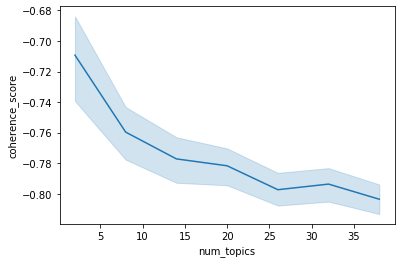

In [76]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [77]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [78]:
lda[id2word.doc2bow(tokenize("This is a sample document to score with a topic distribution."))]

[(0, 0.022248948),
 (1, 0.022248948),
 (2, 0.022248948),
 (3, 0.022248976),
 (4, 0.02224899),
 (5, 0.022248948),
 (6, 0.022248948),
 (7, 0.022248948),
 (8, 0.022248948),
 (9, 0.6885141),
 (10, 0.022249002),
 (11, 0.022249319),
 (12, 0.022248993),
 (13, 0.02224899),
 (14, 0.022248976)]

## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text prepocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow

In [79]:
import spacy

nlp = spacy.load('en_core_web_lg')

c:\users\han-chung lee\.virtualenvs\ds-unit-4-sprint-1-nlp-o1ln3r8m\lib\site-packages\thinc\neural\train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
c:\users\han-chung lee\.virtualenvs\ds-unit-4-sprint-1-nlp-o1ln3r8m\lib\site-packages\thinc\check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable
c:\users\han-chung lee\.virtualenvs\ds-unit-4-sprint-1-nlp-o1ln3r8m\lib\site-packages\thinc\check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [80]:
test = "Ned asked me a question about England today."

In [81]:
doc = nlp(test)

for token in doc:
    print(token.text, token.lemma_, token.pos_)

Ned Ned PROPN
asked ask VERB
me -PRON- PRON
a a DET
question question NOUN
about about ADP
England England PROPN
today today NOUN
. . PUNCT


In [82]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Ned PERSON
England GPE
today DATE


In [83]:
def doc_stream(path):
    for f in os.listdir(path):
        with open(os.path.join(path,f)) as t:
            text = t.read().strip('\n')
            yield text

def get_people(docstream):
    
    ppl = []
    
    for d in docstream:
        
        doc = nlp(d)
        
        for ent in doc.ents:
            
            if ent.label_ == "PERSON":
                ppl.append(ent.lemma_)
                
    return set(ppl)

In [84]:
people = get_people(doc_stream(path))

In [85]:
doc = nlp(next(doc_stream(path)))

In [86]:
doc.ents[0].lemma_

'EMMA'

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)